In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import tempfile
temp_dir = tempfile.TemporaryDirectory()
from casatasks import simobserve, tclean, exportfits
import os
import shutil
from casatools import table
from astropy.constants import c
from astropy.time import Time
import astropy.units as U
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import AdaptiveKernel, GaussianKernel, CubicSplineKernel, DiracDeltaKernel
from natsort import natsorted
import math
from math import pi
from tqdm import tqdm
os.environ['MPLCONFIGDIR'] = temp_dir.name

In [18]:
def load_fits(inFile):
    hdu_list = fits.open(inFile)
    data = hdu_list[0].data
    header = hdu_list[0].header
    hdu_list.close()
    return data, header

def save_fits(outfile, data, header):
    hdu = fits.PrimaryHDU(data, header=header)
    hdul = fits.HDUList([hdu])
    hdul.writeto(outfile, overwrite=True)

def get_band_central_freq(band):
    if band == 3:
        return 100
    elif band == 4:
        return  143
    elif band == 5:
        return  217
    elif band == 6:
        return 250
    elif band == 7:
        return 353
    elif band == 8:
        return 545
    elif band == 9:
        return 650
    elif band == 10:
        return 850

def my_asserteq(*args):
    for aa in args[1:]:
        if args[0] != aa:
            raise RuntimeError(f"{args[0]} != {aa}")

def _ms2resolve_transpose(arr):
    my_asserteq(arr.ndim, 3)
    return np.ascontiguousarray(np.transpose(arr, (0, 2,1)))

def ms_to_npz(ms, dirty_cube, datacolumn='CORRECTED_DATA', output_file='test.npz'):
    tb = table()
    tb.open(ms)
    
    #get frequency info from dirty cube
    with fits.open(dirty_cube, memmap=False) as hdulist: 
            npol, nz,nx, ny = np.shape(hdulist[0].data)
            header=hdulist[0].header
    crdelt3 = header['CDELT3']
    crval3 = header['CRVAL3']
    wave = ((crdelt3 * (np.arange(0, nz, 1))) + crval3) #there will be problems, channels       are not of the same width in real data

    vis = tb.getcol(datacolumn)
    vis = np.ascontiguousarray(_ms2resolve_transpose(vis))

    wgt = tb.getcol('WEIGHT')
    wgt = np.repeat(wgt[:,None],128,axis=1)
    #this is to get vis and wgt on the same shape if ms has column weighted_spectrum this       should be different
    wgt = np.ascontiguousarray(_ms2resolve_transpose(wgt))

    uvw = np.transpose(tb.getcol('UVW'))

    np.savez_compressed(output_file,
                    freq = wave,
                    vis= vis, 
                    weight= wgt,
                    polarization=[9,12], 
                    antpos0=uvw,
                    antpos1=tb.getcol('ANTENNA1'),
                    antpos2=tb.getcol('ANTENNA2'),
                    antpos3=tb.getcol('TIME'))

def get_fov(bands):
    light_speed = c.to(U.m / U.s).value
    fovs = []
    for band in bands:
        if band == 1:
            central_freq = 43 * U.GHz  
        elif band == 3:
            central_freq = 100 * U.GHz
        elif band == 4:
            central_freq = 143 * U.GHz
        elif band == 5:
            central_freq = 217 * U.GHz
        elif band == 6:
            central_freq = 250 * U.GHz
        elif band == 7:
            central_freq = 353 * U.GHz
        elif band == 8:
            central_freq = 545 * U.GHz
        elif band == 9:
            central_freq = 650 * U.GHz    
        elif band == 10:
            central_freq = 850 * U.GHz
           
        central_freq = central_freq.to(U.Hz).value
        central_freq_s = 1 / central_freq
        amplitude = light_speed * central_freq_s
        fov = 1.13 * amplitude / 12
        fov = fov * 180 / np.pi * 3600
        fovs.append(fov)
    return np.array(fovs)

spatial_resolution_dict = {
    'alma.cycle9.3.1' : [3.38, 2.25, 1.83, 1.47, 0.98, 0.74, 0.52, 0.39],
    'alma.cycle9.3.2' : [2.30, 1.53, 1.24, 1.00, 0.67, 0.50, 0.35, 0.26],
    'alma.cycle9.3.3' : [1.42, 0.94, 0.77, 0.62, 0.41, 0.31, 0.22, 0.16],
    'alma.cycle9.3.4' : [0.92, 0.61, 0.50, 0.40, 0.27, 0.20, 0.14, 0.11],
    'alma.cycle9.3.5' : [0.55, 0.36, 0.30, 0.24, 0.16, 0.12, 0.084, 0.063],
    'alma.cycle9.3.6' : [0.31, 0.20, 0.17, 0.13, 0.089, 0.067, 0.047, 0.035],
    'alma.cycle9.3.7' : [0.21, 0.14, 0.11, 0.092, 0.061, 0.046, 0.033, 0.024],
    'alma.cycle9.3.8' : [0.096, 0.064, 0.052, 0.042, 0.028, 0.021, 0.015, 0.011],
    'alma.cycle9.3.9' : [0.057, 0.038, 0.031, 0.025, 0.017, 0.012, 0.088],
    'alma.cycle9.3.10' : [0.042, 0.028, 0.023, 0.018, 0.012, 0.0091]
   
}

def get_spatial_resolution(band, antenna_name):
    if antenna_name == 'alma.cycle.9.3.9':
        assert band <= 9, 'band should be less than 9 for antenna configuration 9'
    elif antenna_name == 'alma.cycle.9.3.10':
        assert band <= 8, 'band should be less than 8 for antenna configuration 10'
    return spatial_resolution_dict[antenna_name][band - 3]

def get_pos(x_radius, y_radius, z_radius):
    x = np.random.randint(-x_radius, x_radius)
    y = np.random.randint(-y_radius, y_radius)
    z = np.random.randint(-z_radius, z_radius)
    return (x, y, z)

def distance_2d(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def distance_1d(p1, p2):
    return math.sqrt((p1-p2)**2)

def distance_3d(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

def sample_positions(pos_x, pos_y, pos_z, n_components, xy_radius, z_radius, sep_xy, sep_z):
    sample = []
    print(len(sample), n_components)
    print(xy_radius, z_radius)
    while len(sample) < n_components:
        print(len(sample))
        new_p = get_pos(xy_radius, xy_radius, z_radius)
        new_p = int(new_p[0] + pos_x), int(new_p[1] + pos_y), int(new_p[2] + pos_z)
        print(new_p)
        if len(sample) == 0:
            spatial_dist = distance_2d((new_p[0],new_p[1]), (pos_x, pos_y))
            freq_dist = distance_1d(new_p[2], pos_z)
            print(spatial_dist, freq_dist, sep_xy, sep_z)
            if  spatial_dist < sep_xy or freq_dist < sep_z:
                continue
            else:
                sample.append(new_p)
        else:
            for p in sample:
                spatial_dist = distance_2d((new_p[0], new_p[1]), (p[0], p[1]))
                freq_dist = distance_1d(new_p[2], p[2])

                if spatial_dist < sep_xy or freq_dist < sep_z:
                    continue
                else:
                    sample.append(new_p)
          
    return sample

def threedgaussian(amplitude, spind, chan, center_x, center_y, width_x, width_y, angle, idxs):
    angle = pi/180. * angle
    rcen_x = center_x * np.cos(angle) - center_y * np.sin(angle)
    rcen_y = center_x * np.sin(angle) + center_y * np.cos(angle)
    xp = idxs[0] * np.cos(angle) - idxs[1] * np.sin(angle)
    yp = idxs[0] * np.sin(angle) + idxs[1] * np.cos(angle)
    v1 = 230e9 - (64 * 10e6)
    v2 = v1+10e6*chan

    g = (10**(np.log10(amplitude) + (spind) * np.log10(v1/v2))) * \
        np.exp(-(((rcen_x-xp)/width_x)**2+((rcen_y-yp)/width_y)**2)/2.)
    return g

def gaussian(x, amp, cen, fwhm):
    """
    Generates a 1D Gaussian given the following input parameters:
    x: position
    amp: amplitude
    fwhm: fwhm
    level: level
    """
    return amp*np.exp(-(x-cen)**2/(2*(fwhm/2.35482)**2))

def insert_gaussian(datacube, pos_x, pos_y, pos_z, fwhm_x, fwhm_y, fwhm_z, pa, n_px, n_chan):
    z_idxs = np.arange(0, n_chan)
    idxs = np.indices([n_px, n_px])
    g = gaussian(z_idxs, 1, pos_z, fwhm_z)
    for z in range(datacube._array.shape[2]):
        ts = threedgaussian(1, 0, z, pos_x, pos_y, fwhm_x, fwhm_y, pa, idxs)
        slice_ = ts + g[z] * ts
        datacube._array[:, :, z, 0] += slice_ * U.Jy * U.pix**-2
    return datacube

def write_datacube_to_fits(
    datacube,
    filename,
    channels="frequency",
    overwrite=True,
    ):
        """
        Output the DataCube to a FITS-format file.

        Parameters
        ----------
        filename : string
            Name of the file to write. '.fits' will be appended if not already
            present.

        channels : {'frequency', 'velocity'}, optional
            Type of units used along the spectral axis in output file.
            (Default: 'frequency'.)

        overwrite: bool, optional
            Whether to allow overwriting existing files. (Default: True.)
        """

        datacube.drop_pad()
        if channels == "frequency":
            datacube.freq_channels()
        elif channels == "velocity":
            datacube.velocity_channels()
        else:
            raise ValueError(
                "Unknown 'channels' value "
                "(use 'frequency' or 'velocity'."
            )

        filename = filename if filename[-5:] == ".fits" else filename + ".fits"

        wcs_header = datacube.wcs.to_header()
        wcs_header.rename_keyword("WCSAXES", "NAXIS")

        header = fits.Header()
        header.append(("SIMPLE", "T"))
        header.append(("BITPIX", 16))
        header.append(("NAXIS", wcs_header["NAXIS"]))
        header.append(("NAXIS1", datacube.n_px_x))
        header.append(("NAXIS2", datacube.n_px_y))
        header.append(("NAXIS3", datacube.n_channels))
        header.append(("NAXIS4", 1))
        header.append(("EXTEND", "T"))
        header.append(("CDELT1", wcs_header["CDELT1"]))
        header.append(("CRPIX1", wcs_header["CRPIX1"]))
        header.append(("CRVAL1", wcs_header["CRVAL1"]))
        header.append(("CTYPE1", wcs_header["CTYPE1"]))
        header.append(("CUNIT1", wcs_header["CUNIT1"]))
        header.append(("CDELT2", wcs_header["CDELT2"]))
        header.append(("CRPIX2", wcs_header["CRPIX2"]))
        header.append(("CRVAL2", wcs_header["CRVAL2"]))
        header.append(("CTYPE2", wcs_header["CTYPE2"]))
        header.append(("CUNIT2", wcs_header["CUNIT2"]))
        header.append(("CDELT3", wcs_header["CDELT3"]))
        header.append(("CRPIX3", wcs_header["CRPIX3"]))
        header.append(("CRVAL3", wcs_header["CRVAL3"]))
        header.append(("CTYPE3", wcs_header["CTYPE3"]))
        header.append(("CUNIT3", wcs_header["CUNIT3"]))
        header.append(("CDELT4", wcs_header["CDELT4"]))
        header.append(("CRPIX4", wcs_header["CRPIX4"]))
        header.append(("CRVAL4", wcs_header["CRVAL4"]))
        header.append(("CTYPE4", wcs_header["CTYPE4"]))
        header.append(("CUNIT4", "PAR"))
        header.append(("EPOCH", 2000))
        # header.append(('BLANK', -32768)) #only for integer data
        header.append(("BSCALE", 1.0))
        header.append(("BZERO", 0.0))
        datacube_array_units = datacube._array.unit
        header.append(
            ("DATAMAX", np.max(datacube._array.to_value(datacube_array_units)))
        )
        header.append(
            ("DATAMIN", np.min(datacube._array.to_value(datacube_array_units)))
        )
        
        # long names break fits format, don't let the user set this
        header.append(("OBJECT", "MOCK"))
        header.append(("BUNIT", datacube_array_units.to_string("fits")))
        header.append(("MJD-OBS", Time.now().to_value("mjd")))
        header.append(("BTYPE", "Intensity"))
        header.append(("SPECSYS", wcs_header["SPECSYS"]))

        # flip axes to write
        hdu = fits.PrimaryHDU(
            header=header, data=datacube._array.to_value(datacube_array_units).T
        )
        hdu.writeto(filename, overwrite=overwrite)

        if channels == "frequency":
            datacube.velocity_channels()
        return

def generate_gaussian_skymodel(id, data_dir, n_sources, n_px, n_channels, bandwidth, 
                               fwhm_x, fwhm_y, fwhm_z, pixel_size, fov,
                               spatial_resolution, central_frequency, 
                               frequency_resolution, pa, min_sep_spatial, min_sep_frequency):
    """
    Generates a gaussian skymodel with n_sources sources
    Input:
    id (int): id of the skymodel
    data_dir (str): directory where the skymodel will be saved
    n_sources (int): number of sources
    n_px (int): number of pixels in the image
    n_channels (int): number of channels in the image
    bandwidth (float): bandwidth in MHz
    distance (float): distance of the source from the observer in Mpc
    fwhm_x (float): fwhm in x direction in arcsec
    fwhm_y (float): fwhm in y direction in arcsec
    fwhm_z (float): fwhm in z direction in MHz
    pixel_size (float): pixel size in arcsec
    fov (float): field of view in arcsec
    spatial_resolution (float): spatial resolution in arcsec
    central_frequency (float): central frequency in GHz
    frequency_resolution (float): frequency resolution in MHz
    pa (float): position angle in degrees\
    min_sep_spatial (float): minimum separation between sources in arcsec
    min_sep_frequency (float): minimum separation between sources in MHz
    """
    fwhm_x = int(fwhm_x.value / pixel_size.value)
    fwhm_y = int(fwhm_y.value / pixel_size.value)
    fwhm_z = int(fwhm_z.value / frequency_resolution.value)
    ra = 0 * U.deg
    dec = 0 * U.deg
    hI_rest_frequency = 1420.4 * U.MHz
    radio_hI_equivalence = U.doppler_radio(hI_rest_frequency)
    central_velocity = central_frequency.to(U.km / U.s, equivalencies=radio_hI_equivalence)
    velocity_resolution = frequency_resolution.to(U.km / U.s, equivalencies=radio_hI_equivalence)
    datacube = DataCube(
    n_px_x = n_px,
    n_px_y = n_px,
    n_channels = n_channels, 
    px_size = spatial_resolution,
    channel_width = velocity_resolution,
    velocity_centre=central_velocity, 
    ra = ra,
    dec = dec,
    )
    wcs = datacube.wcs
    print('Generating central source and {} serendipitous companions'.format(n_sources))
    pos_x, pos_y, pos_z = wcs.sub(3).wcs_world2pix(ra, dec, central_velocity, 0)
    datacube = insert_gaussian(datacube, pos_x, pos_y, pos_z, fwhm_x, fwhm_y, fwhm_z, pa, n_px, n_channels)
    xy_radius = fov / pixel_size * 0.8 
    z_radius = 0.5 * bandwidth / frequency_resolution
    print('Generating sources in a radius of {} pixels in the x and y directions and {} in the z'.format(xy_radius, z_radius))
    min_sep_xy = min_sep_spatial / pixel_size
    min_sep_z = min_sep_frequency / frequency_resolution
    sample_coords = sample_positions(pos_x, pos_y, pos_z, n_sources, xy_radius.value, z_radius.value, min_sep_xy.value, min_sep_z.value)
    fwhm_xs = np.random.randint(2, 10, n_sources)
    fwhm_ys = np.random.randint(2, 10, n_sources)
    fwhm_zs = np.random.randint(2, 30, n_sources)
    pas = np.random.randint(0, 360, n_sources)
    for i, choords in tqdm(enumerate(sample_coords), total=len(sample_coords), desc='Inserting source {} at {} with size {} {} {}'.format(i, choords, fwhm_xs[i], fwhm_ys[i], fwhm_zs[i])):
        datacube = insert_gaussian(datacube, choords[0], choords[1], choords[2], fwhm_xs[i], fwhm_ys[i], fwhm_zs[i], pas[i], n_px, n_channels)
    filename = os.path.join(data_dir, 'skymodel_{}.fits'.format(id))
    write_datacube_to_fits(datacube, filename)
    del datacube
    return filename

def generate_extended_skymodel():
    return

def simulator(i, data_dir, main_path, project_name, output_dir, band, antenna_name, inbright, 
                bandwidth, inwidth, integration, totaltime, pwv, snr, get_skymodel=False,
                extended=False, debug=False, plot=False):
    """
    Input:
    i: index of the file to be simulated
    data_dir: directory where the data is stored
    main_path: path to the ALMASim Folder on your machine
    project_name: name of the project
    output_dir: directory where the output is stored
    band (int): band to be simulated (3 - 10)
    antenna_name (str): name of the antenna configuration (alma.cycle9.3.1 - alma.cycle9.3.10)
    inbright (float): brightness of the source in Jy/px (0.000001 - 0.1)
    bandwidth (float): bandwidth in MHz (1000)
    inwidth (float): channel width in MHz (10 - 100)
    integration (float): integration time in seconds (0.1 - 10)
    totaltime (float): total time in seconds (1000 - 7000)
    pwv (float): precipitable water vapor in mm (0.1 - 1)
    snr (float): signal to noise ratio (5 - 30)
    get_skymodel (bool): if True, skymodels are loaded from the data_dir, else they are generated
    Output:
    None
    """
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    project = project_name + '_{}'.format(i)
    if not os.path.exists(project):
        os.mkdir(project)

    spatial_resolution = get_spatial_resolution(band, antenna_name)
    central_freq= get_band_central_freq(band)
    fov = get_fov([band])[0]
    pixel_size = spatial_resolution / 7
    n_px = int(1.5 * fov / pixel_size)
    n_channels = int(bandwidth / inwidth)
    print('Simulation Parameters given Band and Spatial Resolution')
    print('Band ', band)
    print('Bandwidth ', bandwidth, ' MHz')
    print('Central Frequency ', central_freq, ' GHz')
    print('n_px ', n_px)
    print('pixel_size ', pixel_size, ' arcsec')
    print('fov ', fov, ' arcsec')
    print('spatial_resolution ', spatial_resolution, ' arcsec')
    print('Antenna Configuration ', antenna_name)

    if get_skymodel:
        print('Reading Skymodel from {}'.format(data_dir))
        files = natsorted(os.listdir(data_dir))
        files = [os.path.join(data_dir, file) for file in files if '.fits' in file]
        filename = files[i]
    else:
        if extended:
            print('Generating Extended Emission Skymodel from TNG')
            filename = generate_extended_skymodel() 
        else:
            print('Generating Gaussian Skymodel')
            n_sources = np.random.randint(1, 5)
            fwhm_x = (0.1 * fov - 0.01 * fov)*np.random.rand() + 0.01 * fov
            fwhm_y = (0.1 * fov - 0.01 * fov)*np.random.rand() + 0.01 * fov
            fwhm_z = (0.1 * bandwidth - 0.01 * bandwidth)*np.random.rand() + 0.01 * bandwidth
            pa = np.random.randint(0, 360)
            print('Number of Sources ', n_sources)
            print('FWHM_x ', fwhm_x, ' arcsec')
            print('FWHM_y ', fwhm_y, ' arcsec')
            print('FWHM_z ', fwhm_z, ' MHz')
            print('PA ', pa, ' deg')
            min_sep_spatial = 1.5 * spatial_resolution
            min_sep_frequency = 1.5 * inwidth
            filename = generate_gaussian_skymodel(i, output_dir, n_sources,
                                                  n_px, n_channels, bandwidth, 
                                                  fwhm_x * U.arcsec, fwhm_y * U.arcsec, 
                                                  fwhm_z * U.MHz,
                                                  pixel_size * U.arcsec,  
                                                  fov * U.arcsec, 
                                                  spatial_resolution * U.arcsec, 
                                                  central_freq * U.GHz,
                                                  inwidth * U.MHz, 
                                                  pa, 
                                                  min_sep_spatial, 
                                                  min_sep_frequency)
    
    data, header =  load_fits(filename)
    if debug:
        print('Data Shape ', data.shape)
        
    blank_data = np.zeros(data.shape)
    blankname = os.path.join(project,'blank.fits')

    save_fits(blankname, blank_data, header)

    antennalist = os.path.join(main_path, "antenna_config", antenna_name + '.cfg')
    print('Generating Noise')
    simobserve(
        project=project, 
        skymodel=blankname,
        inbright="{}Jy/pix".format(inbright),
        incell="{}arcsec".format(pixel_size),
        indirection="J2000 19h30m00 -40d00m00",
        incenter='{}GHz'.format(central_freq),
        inwidth="{}MHz".format(inwidth),
        setpointings=True,
        integration="{}s".format(integration),
        mapsize=["{}arcsec".format(fov)],
        maptype="square",
        obsmode="int",
        antennalist=antennalist,
        totaltime="{}s".format(totaltime),
        thermalnoise="tsys-atm",
        user_pwv=pwv,
        seed=11111,
        graphics="none",
        verbose=False,
        overwrite=True)
    tclean(
        vis=os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
        imagename=os.path.join(project, '{}.{}'.format(project, antenna_name)),
        imsize=[int(n_px), int(n_px)],
        cell="{}arcsec".format(pixel_size),
        phasecenter="J2000 19h30m00 -40d00m00",
        specmode="cube",
        niter=0,
        fastnoise=False,
        calcpsf=True,
        pbcor=False
        )
    exportfits(imagename=os.path.join(project, '{}.{}.image'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "noise_cube_" + str(i) +".fits"), overwrite=True)
    noise, header = load_fits(os.path.join(output_dir, "noise_cube_" + str(i) +".fits"))
    noise_rmse = np.sqrt(np.nanmean(noise**2))
    print('Noise RMSE ', noise_rmse)
    inbright = snr * noise_rmse
    print('Simulating ALMA Observation of the Skymodel')
    simobserve(
        project=project, 
        skymodel=filename,
        inbright="{}Jy/pix".format(inbright),
        incell="{}arcsec".format(pixel_size),
        indirection="J2000 19h30m00 -40d00m00",
        incenter='{}GHz'.format(central_freq),
        inwidth="{}MHz".format(inwidth),
        setpointings=True,
        integration="{}s".format(integration),
        mapsize=["{}arcsec".format(fov)],
        maptype="square",
        obsmode="int",
        antennalist=antennalist,
        totaltime="{}s".format(totaltime),
        thermalnoise="tsys-atm",
        user_pwv=pwv,
        seed=11111,
        graphics="none",
        verbose=False,
        overwrite=True)
    
    tclean(
        vis=os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
        imagename=os.path.join(project, '{}.{}'.format(project, antenna_name)),
        imsize=[int(n_px), int(n_px)],
        cell="{}arcsec".format(pixel_size),
        phasecenter="J2000 19h30m00 -40d00m00",
        specmode="cube",
        niter=0,
        fastnoise=False,
        calcpsf=True,
        pbcor=False
        )

    print('Saving Dirty and Clean Cubes')
    exportfits(imagename=os.path.join(project, '{}.{}.image'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"), overwrite=True)
    exportfits(imagename=os.path.join(project, '{}.{}.skymodel'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "clean_cube_" + str(i) +".fits"), overwrite=True)
    print('Saving Measurement Set')
    ms_to_npz(os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
              dirty_cube=os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"),
              datacolumn='CORRECTED_DATA',
              output_file=os.path.join(output_dir, "{}.{}.noisy_".format(project, antenna_name) + str(i) +".npz"))
    shutil.rmtree(project)
    if plot:
        plotter(i, output_dir)
    
def plotter(i, output_dir):
    clean, _ = load_fits(os.path.join(output_dir, 'clean_cube_{}.fits'.format(i)))
    dirty, _ = load_fits(os.path.join(output_dir, 'dirty_cube_{}.fits'.format(i)))
    if clean.shape[1] > 1:
        clean = np.sum(clean[0, :, :, :], axis=0)
        dirty = np.sum(dirty[0, :, :, :], axis=0)
    else:
        clean = clean[0, 0, :, :]
        dirty = dirty[0, 0, :, :]
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(clean, origin='lower')
    ax[1].imshow(dirty, origin='lower')
    plt.show()


In [ ]:
i = 1
datadir = '/media/storage'
output_dir = 'sims'
output_dir = os.path.join(datadir, output_dir)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
project = 'sim_{}'.format(i)
name = 'sky_{}.fits'.format(i)
filename = os.path.join(datadir, name)

antenna_name = 'alma.cycle9.3.3'
# Computing the number of pixels
band = 6
spatial_resolution = get_spatial_resolution(band, antenna_name)
central_freq = get_band_central_freq(band)
fov = get_fov([band])[0]
pixel_size = spatial_resolution / 7
# Add 0.2 pb to the fov
n_px = int(1.5* fov / pixel_size)

# Fixing the number of pixels
#n_px = 300
#pixel_size = fov / n_px
#spatial_resolution = pixel_size * 7



print('Simulation Parameters given Band and Spatial Resolution')
print('Band ', band)
print('Central Frequency ', central_freq, ' GHz')
print('n_px ', n_px)
print('pixel_size ', pixel_size, ' arcsec')
print('fov ', fov, ' arcsec')
print('spatial_resolution ', spatial_resolution, ' arcsec')
print('Antenna Configuration ', antenna_name)

antennalist = os.path.join('/home/michele/GitHub/ALMASim/antenna_config', antenna_name + '.cfg')

print('Generating Noise')

print(type(central_freq))
#between 1 milliJy and 0.1 Jy
# make first an image of only noise, measure the RMS. Then go for a peak signal of 30 times that RMS. 
# First inbright, then RMS, then new inbright 30 times that. 
# The RMS must be computed per plane
simobserve(
        project=project, 
        skymodel=filename,
        inbright="0.001Jy/pix",
        incell="{}arcsec".format(pixel_size),
        indirection="J2000 19h30m00 -40d00m00",
        incenter="{}GHz".format(central_freq),
        inwidth="10MHz",
        setpointings=True,
        integration="10s",
        mapsize=["{}arcsec".format(fov)],
        maptype="square",
        obsmode="int",
        antennalist=antennalist,
        totaltime="2400s",
        thermalnoise="tsys-atm",
        user_pwv=0.0,
        seed=11111,
        graphics="none",
        verbose=False,
        overwrite=True)
tclean(
        vis=os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
        imagename=os.path.join(project, '{}.{}'.format(project, antenna_name)),
        imsize=[int(n_px), int(n_px)],
        cell="{}arcsec".format(pixel_size),
        phasecenter="J2000 19h30m00 -40d00m00",
        specmode="cube",
        niter=0,
        fastnoise=False,
        calcpsf=True,
        pbcor=False
        )
exportfits(imagename=os.path.join(project, '{}.{}.image'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"), overwrite=True)
exportfits(imagename=os.path.join(project, '{}.{}.skymodel'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "clean_cube_" + str(i) +".fits"), overwrite=True)

ms_to_npz(os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
              dirty_cube=os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"),
              datacolumn='CORRECTED_DATA',
              output_file=os.path.join(output_dir, "{}.{}.noisy_".format(project, antenna_name) + str(i) +".npz"))
shutil.rmtree(project)

clean_data, clean_header = load_fits(os.path.join(output_dir, "clean_cube_" + str(i) +".fits"))
dirty_data, dirty_header = load_fits(os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"))


print('Printing Clean Header')
for key, value in clean_header.items():
        print(key, value)
print("\n\n")
print('Clean Data Stats')
print('Max: ', np.max(clean_data))
print('Min: ', np.min(clean_data))
print('Mean: ', np.mean(clean_data))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.log10(clean_data[0, 0, :, :]), origin='lower')
ax[1].imshow(dirty_data[0, 0, :, :], origin='lower')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(np.log10(clean_data.flatten()), bins=100)
plt.xlabel('log10(Jy/beam)')
plt.ylabel('N')
plt.title('Histogram of the Clean Cube')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(np.log10(dirty_data.flatten()), bins=100)
plt.xlabel('log10(Jy/beam)')
plt.ylabel('N')
plt.title('Histogram of the Dirty Cube')
plt.show()

In [19]:
i = 3
datadir = '/media/storage'
main_path = '/home/deepfocus/ALMASim'
output_dir = 'sims'
outputdir = os.path.join(datadir, output_dir)
project_name = 'sim'
band = 6
antenna_name = 'alma.cycle9.3.3'
inbright = 0.001
bandwidth = 900
inwidth = 10
integration = 10
totaltime = 2500
pwv = 0.3
snr = 30
debug = True

simulator(i, datadir, main_path, project_name, outputdir, band, antenna_name, inbright, bandwidth, inwidth, integration, totaltime, pwv, snr, debug=debug)

Simulation Parameters given Band and Spatial Resolution
Band  6
Bandwidth  900  MHz
Central Frequency  250  GHz
n_px  394
pixel_size  0.08857142857142856  arcsec
fov  23.291798529331054  arcsec
spatial_resolution  0.62  arcsec
Antenna Configuration  alma.cycle9.3.3
Generating Gaussian Skymodel
18.565945162184427
Number of Sources  4
FWHM_x  1.211780414299509  arcsec
FWHM_y  1.0915359141086691  arcsec
FWHM_z  18.565945162184427  MHz
PA  258  deg
Generating central source and 4 serendipitous companions
Generating sources in a radius of 210.37753510363532 pixels in the x and y directions and 45.0 1 / MHz in the z
0 4
210.37753510363532 45.0
0
(162, 306, 247)
114.80635870893416 26.428658252977897 10.5 1.5
1
(208, 306, 253)
2
(259, 34, 222)


0it [00:00, ?it/s]

Inserting source 0 at (162, 306, 247) with size 5 8 23


1it [00:00,  3.18it/s]

Inserting source 1 at (208, 306, 253) with size 5 2 12


2it [00:00,  3.16it/s]

Inserting source 2 at (259, 34, 222) with size 4 6 20


3it [00:00,  3.17it/s]

Inserting source 3 at (259, 34, 222) with size 6 3 25


4it [00:01,  3.17it/s]


Data Shape  (1, 90, 394, 394)
Generating Noise


/home/deepfocus/anaconda3/envs/casa6.5/lib/python3.8/site-packages/casatasks/private/simutil.py:2571: RuntimeWarning: divide by zero encountered in double_scalars
  scalefactor=float(inbright)/pl.nanmax(arr)
/home/deepfocus/anaconda3/envs/casa6.5/lib/python3.8/site-packages/casatasks/private/simutil.py:2966: RuntimeWarning: invalid value encountered in multiply
  ia.putchunk(arr*scalefactor)


WARN: model is empty.


....10....20....30....40....50....60....70....80....90....100%
2023-04-06 09:17:14	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2086)	imsize with 394 pixels is not an efficient imagesize. Try 400 instead.
2023-04-06 09:17:28	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2086)	imsize with 394 pixels is not an efficient imagesize. Try 400 instead.
2023-04-06 09:17:39	WARN	task_tclean::SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2086)	imsize with 394 pixels is not an efficient imagesize. Try 400 instead.
2023-04-06 09:17:46	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2265)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


Noise RMSE  0.0004031923
Simulating ALMA Observation of the Skymodel


....10....20....30....40....50....60....70....80....90....100%
2023-04-06 09:20:12	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2086)	imsize with 394 pixels is not an efficient imagesize. Try 400 instead.
2023-04-06 09:20:12	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2086)	imsize with 394 pixels is not an efficient imagesize. Try 400 instead.
2023-04-06 09:20:28	WARN	task_tclean::SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2086)	imsize with 394 pixels is not an efficient imagesize. Try 400 instead.
2023-04-06 09:20:35	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2265)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


Saving Dirty and Clean Cubes
Saving Measurement Set


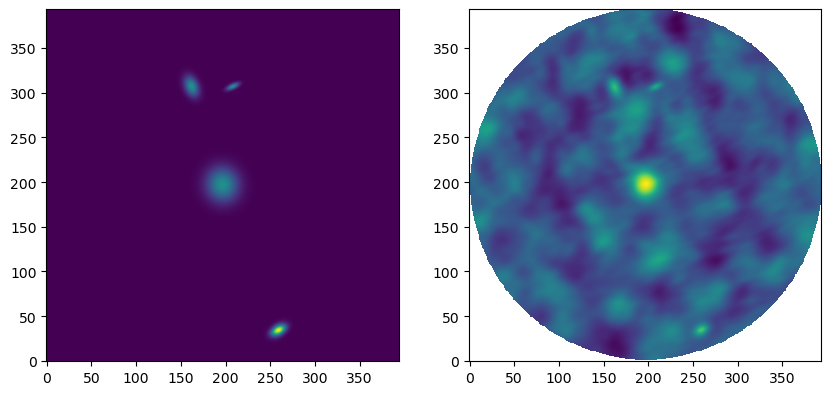

In [21]:
i = 3
datadir = '/media/storage'
main_path = '/home/deepfocus/ALMASim'
output_dir = 'sims'
plotter(i, datadir, output_dir)